In [1]:
import os
from tqdm import tqdm
from src.utils import *
from src.params import *
from ranger import Ranger20
import matplotlib.pyplot as plt
from src.models import FCN, UNet
from src.dataset import RapidEye
from torch.nn import CrossEntropyLoss
from sklearn.metrics import jaccard_score
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split
from albumentations import Compose, HorizontalFlip, VerticalFlip, Normalize, RandomCrop, CenterCrop

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
normalize = Normalize(mean=train_mean_full, std=train_std_full)

train_transforms = Compose([
    VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

test_transforms = Compose([
    CenterCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

In [4]:
train_dataset = RapidEye(
    band="Full",
    img_dir=train_path,
    mask_dir=mask_path,
    transform=train_transforms
)
train_dataset, val_dataset = random_split(
    train_dataset,
    lengths=[int(len(train_dataset) * 0.8), len(train_dataset) - int(len(train_dataset) * 0.8)]
)
test_dataset = RapidEye(
    band="Full",
    mask_dir=None,
    img_dir=test_path,
    transform=test_transforms
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
val_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=val_dataset,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
test_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_dataset,
    pin_memory=True,
    num_workers=0,
)

In [5]:
model = FCN(n_classes=3, n_bands=5, pretrained=False)
model = model.to(device)
criterion = CrossEntropyLoss()
optimizer = Ranger20(model.parameters())

records = { "train_loss": [], "val_loss": [], "val_iou": [], "val_acc": [] }

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [6]:
for epoch in range(EPOCH):
    model.train()

    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        x, mask = data
        x = x.to(device)
        mask = mask.to(device)
        y_pred = model(x)

        loss = criterion(y_pred["out"], mask)
        train_loss += loss
        
        if "aux" in y_pred.keys():
            train_loss += 0.4 * criterion(y_pred["aux"], mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Iteration {i} / Epoch {epoch}: Training Loss {loss}")
    train_loss /= len(train_loader)
    records["train_loss"].append(train_loss.item())

    with torch.no_grad():
        model.eval()
        val_iou = 0
        val_acc = 0
        val_loss = 0

        for i, data in tqdm(enumerate(val_loader)):
            x, mask = data
            x = x.to(device)
            mask = mask.to(device)
            y_pred = model(x)
            y_pred = y_pred["out"]

            loss = criterion(y_pred, mask)
            val_loss += loss

            y_pred = y_pred.argmax(axis=1)
            val_acc += torch.eq(y_pred, mask).float().mean()
            val_iou += jaccard_score(y_pred.reshape(-1).cpu(), mask.reshape(-1).cpu(), average="weighted")

    val_acc /= len(val_loader)
    val_iou /= len(val_loader)
    val_loss /= len(val_loader)

    records["val_acc"].append(val_acc.item())
    records["val_iou"].append(val_iou.item())
    records["val_loss"].append(val_loss.item())

    print(f"Epoch {epoch}: Validation Loss {val_loss} | Validation Pixel-wise Accuracy: {val_acc} | Validation IoU: {val_iou}")

10it [00:05,  1.81it/s]

Iteration 9 / Epoch 0: Training Loss 0.9781890511512756


20it [00:10,  1.84it/s]

Iteration 19 / Epoch 0: Training Loss 0.6702365279197693


30it [00:15,  2.01it/s]

Iteration 29 / Epoch 0: Training Loss 0.7367833852767944


40it [00:19,  2.04it/s]

Iteration 39 / Epoch 0: Training Loss 0.5323949456214905


45it [00:22,  2.03it/s]
12it [00:04,  2.43it/s]
0it [00:00, ?it/s]

Epoch 0: Validation Loss 1.305351734161377 | Validation Pixel-wise Accuracy: 0.43723011016845703 | Validation IoU: 0.375202163535475


10it [00:03,  2.31it/s]

Iteration 9 / Epoch 1: Training Loss 0.639959990978241


20it [00:07,  2.47it/s]

Iteration 19 / Epoch 1: Training Loss 0.6072317957878113


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 1: Training Loss 0.4661543667316437


40it [00:15,  2.29it/s]

Iteration 39 / Epoch 1: Training Loss 0.44541215896606445


45it [00:16,  2.68it/s]
12it [00:04,  2.92it/s]
0it [00:00, ?it/s]

Epoch 1: Validation Loss 8.009669303894043 | Validation Pixel-wise Accuracy: 0.20518557727336884 | Validation IoU: 0.18171633369440285


10it [00:03,  2.35it/s]

Iteration 9 / Epoch 2: Training Loss 0.48668941855430603


20it [00:07,  2.24it/s]

Iteration 19 / Epoch 2: Training Loss 0.5717260241508484


30it [00:11,  2.35it/s]

Iteration 29 / Epoch 2: Training Loss 0.475328654050827


40it [00:15,  2.33it/s]

Iteration 39 / Epoch 2: Training Loss 0.4082675576210022


45it [00:17,  2.60it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 2: Validation Loss 8.89693546295166 | Validation Pixel-wise Accuracy: 0.23116526007652283 | Validation IoU: 0.20204814615413136


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 3: Training Loss 0.4837924838066101


20it [00:07,  2.40it/s]

Iteration 19 / Epoch 3: Training Loss 0.4552047848701477


30it [00:11,  2.22it/s]

Iteration 29 / Epoch 3: Training Loss 0.30611327290534973


40it [00:15,  2.23it/s]

Iteration 39 / Epoch 3: Training Loss 0.3552907109260559


45it [00:17,  2.61it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 3: Validation Loss 1.459668517112732 | Validation Pixel-wise Accuracy: 0.1991739273071289 | Validation IoU: 0.12811348784406962


10it [00:03,  2.47it/s]

Iteration 9 / Epoch 4: Training Loss 0.333454430103302


20it [00:07,  2.30it/s]

Iteration 19 / Epoch 4: Training Loss 0.2887721359729767


30it [00:11,  2.45it/s]

Iteration 29 / Epoch 4: Training Loss 0.4786829948425293


40it [00:14,  2.45it/s]

Iteration 39 / Epoch 4: Training Loss 0.277128666639328


45it [00:16,  2.70it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 4: Validation Loss 1.412856936454773 | Validation Pixel-wise Accuracy: 0.23869991302490234 | Validation IoU: 0.1931922019879979


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 5: Training Loss 0.3676595389842987


20it [00:07,  2.47it/s]

Iteration 19 / Epoch 5: Training Loss 0.34516990184783936


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 5: Training Loss 0.5330471396446228


40it [00:15,  2.25it/s]

Iteration 39 / Epoch 5: Training Loss 0.3106602132320404


45it [00:16,  2.67it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 5: Validation Loss 6.504087448120117 | Validation Pixel-wise Accuracy: 0.3470630645751953 | Validation IoU: 0.3466067223194733


10it [00:03,  2.46it/s]

Iteration 9 / Epoch 6: Training Loss 0.26493969559669495


20it [00:07,  2.35it/s]

Iteration 19 / Epoch 6: Training Loss 0.35558831691741943


30it [00:11,  2.45it/s]

Iteration 29 / Epoch 6: Training Loss 0.4163045585155487


40it [00:14,  2.43it/s]

Iteration 39 / Epoch 6: Training Loss 0.33542516827583313


45it [00:16,  2.69it/s]
12it [00:03,  3.06it/s]
0it [00:00, ?it/s]

Epoch 6: Validation Loss 1.5757560729980469 | Validation Pixel-wise Accuracy: 0.20792898535728455 | Validation IoU: 0.1878140971568714


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 7: Training Loss 0.2582395076751709


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 7: Training Loss 0.26155900955200195


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 7: Training Loss 0.4277091920375824


40it [00:15,  2.17it/s]

Iteration 39 / Epoch 7: Training Loss 0.2573128938674927


45it [00:17,  2.62it/s]
12it [00:03,  3.07it/s]
0it [00:00, ?it/s]

Epoch 7: Validation Loss 31.06489372253418 | Validation Pixel-wise Accuracy: 0.2601725459098816 | Validation IoU: 0.20647233497173403


10it [00:03,  2.42it/s]

Iteration 9 / Epoch 8: Training Loss 0.278719961643219


20it [00:07,  2.33it/s]

Iteration 19 / Epoch 8: Training Loss 0.2735568881034851


30it [00:11,  2.43it/s]

Iteration 29 / Epoch 8: Training Loss 0.3634347915649414


40it [00:14,  2.42it/s]

Iteration 39 / Epoch 8: Training Loss 0.35906487703323364


45it [00:16,  2.68it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 8: Validation Loss 12.266192436218262 | Validation Pixel-wise Accuracy: 0.3544715344905853 | Validation IoU: 0.3147932506468107


10it [00:03,  2.29it/s]

Iteration 9 / Epoch 9: Training Loss 0.27669453620910645


20it [00:07,  2.44it/s]

Iteration 19 / Epoch 9: Training Loss 0.24753537774085999


30it [00:11,  2.38it/s]

Iteration 29 / Epoch 9: Training Loss 0.3099755048751831


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 9: Training Loss 0.34333860874176025


45it [00:16,  2.65it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 9: Validation Loss 4.792845726013184 | Validation Pixel-wise Accuracy: 0.2761523127555847 | Validation IoU: 0.21123182756953382


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 10: Training Loss 0.2830933630466461


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 10: Training Loss 0.30357763171195984


30it [00:11,  2.45it/s]

Iteration 29 / Epoch 10: Training Loss 0.3137873113155365


40it [00:15,  2.35it/s]

Iteration 39 / Epoch 10: Training Loss 0.2966526448726654


45it [00:16,  2.66it/s]
12it [00:04,  2.93it/s]
0it [00:00, ?it/s]

Epoch 10: Validation Loss 1.0291410684585571 | Validation Pixel-wise Accuracy: 0.43387889862060547 | Validation IoU: 0.35866083646435687


10it [00:03,  2.26it/s]

Iteration 9 / Epoch 11: Training Loss 0.2904105484485626


20it [00:07,  2.41it/s]

Iteration 19 / Epoch 11: Training Loss 0.31421780586242676


30it [00:11,  2.38it/s]

Iteration 29 / Epoch 11: Training Loss 0.27878454327583313


40it [00:15,  2.21it/s]

Iteration 39 / Epoch 11: Training Loss 0.29620978236198425


45it [00:17,  2.63it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 11: Validation Loss 11.740535736083984 | Validation Pixel-wise Accuracy: 0.24568557739257812 | Validation IoU: 0.18676726275113456


10it [00:03,  2.44it/s]

Iteration 9 / Epoch 12: Training Loss 0.33609333634376526


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 12: Training Loss 0.3226883113384247


30it [00:11,  2.44it/s]

Iteration 29 / Epoch 12: Training Loss 0.28599247336387634


40it [00:15,  2.41it/s]

Iteration 39 / Epoch 12: Training Loss 0.27579832077026367


45it [00:16,  2.66it/s]
12it [00:03,  3.00it/s]
0it [00:00, ?it/s]

Epoch 12: Validation Loss 8.213830947875977 | Validation Pixel-wise Accuracy: 0.2257223129272461 | Validation IoU: 0.17970439985256595


10it [00:03,  2.29it/s]

Iteration 9 / Epoch 13: Training Loss 0.2698643207550049


20it [00:07,  2.44it/s]

Iteration 19 / Epoch 13: Training Loss 0.24471651017665863


30it [00:11,  2.39it/s]

Iteration 29 / Epoch 13: Training Loss 0.2665579617023468


40it [00:15,  2.25it/s]

Iteration 39 / Epoch 13: Training Loss 0.3082698583602905


45it [00:17,  2.64it/s]
12it [00:04,  3.00it/s]
0it [00:00, ?it/s]

Epoch 13: Validation Loss 65.15644836425781 | Validation Pixel-wise Accuracy: 0.33608150482177734 | Validation IoU: 0.3182712534768126


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 14: Training Loss 0.2721569836139679


20it [00:07,  2.29it/s]

Iteration 19 / Epoch 14: Training Loss 0.3836685121059418


30it [00:11,  2.42it/s]

Iteration 29 / Epoch 14: Training Loss 0.23167365789413452


40it [00:15,  2.42it/s]

Iteration 39 / Epoch 14: Training Loss 0.34991034865379333


45it [00:16,  2.67it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 14: Validation Loss 93.24716186523438 | Validation Pixel-wise Accuracy: 0.382403701543808 | Validation IoU: 0.2727903219689439


10it [00:03,  2.18it/s]

Iteration 9 / Epoch 15: Training Loss 0.22874532639980316


20it [00:07,  2.44it/s]

Iteration 19 / Epoch 15: Training Loss 0.39726805686950684


30it [00:11,  2.38it/s]

Iteration 29 / Epoch 15: Training Loss 0.29418858885765076


40it [00:15,  2.26it/s]

Iteration 39 / Epoch 15: Training Loss 0.2661726772785187


45it [00:17,  2.64it/s]
12it [00:04,  2.98it/s]
0it [00:00, ?it/s]

Epoch 15: Validation Loss 3.1422476768493652 | Validation Pixel-wise Accuracy: 0.20653598010540009 | Validation IoU: 0.2064113975750943


10it [00:03,  2.41it/s]

Iteration 9 / Epoch 16: Training Loss 0.28139203786849976


20it [00:07,  2.25it/s]

Iteration 19 / Epoch 16: Training Loss 0.2706843614578247


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 16: Training Loss 0.44659969210624695


40it [00:15,  2.40it/s]

Iteration 39 / Epoch 16: Training Loss 0.2244592308998108


45it [00:17,  2.64it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 16: Validation Loss 2.9295527935028076 | Validation Pixel-wise Accuracy: 0.24638430774211884 | Validation IoU: 0.1838302811747551


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 17: Training Loss 0.2724076807498932


20it [00:07,  2.42it/s]

Iteration 19 / Epoch 17: Training Loss 0.3133311867713928


30it [00:11,  2.33it/s]

Iteration 29 / Epoch 17: Training Loss 0.2648129165172577


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 17: Training Loss 0.22208736836910248


45it [00:17,  2.63it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 17: Validation Loss 1.598157286643982 | Validation Pixel-wise Accuracy: 0.3805580139160156 | Validation IoU: 0.37149272730596355


10it [00:03,  2.37it/s]

Iteration 9 / Epoch 18: Training Loss 0.2965238690376282


20it [00:07,  2.13it/s]

Iteration 19 / Epoch 18: Training Loss 0.21286579966545105


30it [00:11,  2.36it/s]

Iteration 29 / Epoch 18: Training Loss 0.2591913640499115


40it [00:15,  1.87it/s]

Iteration 39 / Epoch 18: Training Loss 0.31303074955940247


45it [00:17,  2.53it/s]
12it [00:04,  2.82it/s]
0it [00:00, ?it/s]

Epoch 18: Validation Loss 3.771472692489624 | Validation Pixel-wise Accuracy: 0.4110543131828308 | Validation IoU: 0.35739860902901427


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 19: Training Loss 0.3051564693450928


20it [00:08,  1.96it/s]

Iteration 19 / Epoch 19: Training Loss 0.35484373569488525


30it [00:13,  1.56it/s]

Iteration 29 / Epoch 19: Training Loss 0.2745150625705719


40it [00:18,  1.81it/s]

Iteration 39 / Epoch 19: Training Loss 0.19661428034305573


45it [00:20,  2.18it/s]
12it [00:04,  2.77it/s]
0it [00:00, ?it/s]

Epoch 19: Validation Loss 1.360092043876648 | Validation Pixel-wise Accuracy: 0.22279581427574158 | Validation IoU: 0.1997911867543063


10it [00:04,  2.00it/s]

Iteration 9 / Epoch 20: Training Loss 0.2353028953075409


20it [00:08,  2.22it/s]

Iteration 19 / Epoch 20: Training Loss 0.2851027548313141


30it [00:12,  2.39it/s]

Iteration 29 / Epoch 20: Training Loss 0.2487218976020813


40it [00:16,  2.41it/s]

Iteration 39 / Epoch 20: Training Loss 0.33568811416625977


45it [00:17,  2.51it/s]
12it [00:04,  2.94it/s]
0it [00:00, ?it/s]

Epoch 20: Validation Loss 6.888362407684326 | Validation Pixel-wise Accuracy: 0.3433939814567566 | Validation IoU: 0.33552864530444143


10it [00:03,  2.28it/s]

Iteration 9 / Epoch 21: Training Loss 0.2773536443710327


20it [00:07,  2.38it/s]

Iteration 19 / Epoch 21: Training Loss 0.28537437319755554


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 21: Training Loss 0.22608903050422668


40it [00:15,  2.28it/s]

Iteration 39 / Epoch 21: Training Loss 0.2805420160293579


45it [00:17,  2.63it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 21: Validation Loss 36.458839416503906 | Validation Pixel-wise Accuracy: 0.3469022214412689 | Validation IoU: 0.3460812687969028


10it [00:03,  2.39it/s]

Iteration 9 / Epoch 22: Training Loss 0.2567940056324005


20it [00:07,  2.30it/s]

Iteration 19 / Epoch 22: Training Loss 0.32754650712013245


30it [00:11,  2.42it/s]

Iteration 29 / Epoch 22: Training Loss 0.2729647159576416


40it [00:15,  2.39it/s]

Iteration 39 / Epoch 22: Training Loss 0.35953375697135925


45it [00:16,  2.65it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 22: Validation Loss 10.497879981994629 | Validation Pixel-wise Accuracy: 0.26747769117355347 | Validation IoU: 0.20856403897839929


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 23: Training Loss 0.29098212718963623


20it [00:07,  2.42it/s]

Iteration 19 / Epoch 23: Training Loss 0.29013141989707947


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 23: Training Loss 0.23921889066696167


40it [00:15,  2.22it/s]

Iteration 39 / Epoch 23: Training Loss 0.33894795179367065


45it [00:17,  2.62it/s]
12it [00:03,  3.06it/s]
0it [00:00, ?it/s]

Epoch 23: Validation Loss 3.1521003246307373 | Validation Pixel-wise Accuracy: 0.2518339157104492 | Validation IoU: 0.24874466135299844


10it [00:03,  2.35it/s]

Iteration 9 / Epoch 24: Training Loss 0.19856303930282593


20it [00:07,  2.30it/s]

Iteration 19 / Epoch 24: Training Loss 0.238779217004776


30it [00:11,  2.32it/s]

Iteration 29 / Epoch 24: Training Loss 0.25200676918029785


40it [00:15,  2.35it/s]

Iteration 39 / Epoch 24: Training Loss 0.2799588143825531


45it [00:17,  2.62it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 24: Validation Loss 1.2107291221618652 | Validation Pixel-wise Accuracy: 0.37729454040527344 | Validation IoU: 0.3761105835212384


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 25: Training Loss 0.2944716513156891


20it [00:07,  2.37it/s]

Iteration 19 / Epoch 25: Training Loss 0.31776300072669983


30it [00:11,  2.38it/s]

Iteration 29 / Epoch 25: Training Loss 0.3777311444282532


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 25: Training Loss 0.19514289498329163


45it [00:17,  2.64it/s]
12it [00:03,  3.00it/s]
0it [00:00, ?it/s]

Epoch 25: Validation Loss 2.3476123809814453 | Validation Pixel-wise Accuracy: 0.20502154529094696 | Validation IoU: 0.20378339404579382


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 26: Training Loss 0.22914764285087585


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 26: Training Loss 0.28367090225219727


30it [00:11,  2.44it/s]

Iteration 29 / Epoch 26: Training Loss 0.24141184985637665


40it [00:15,  2.42it/s]

Iteration 39 / Epoch 26: Training Loss 0.3181939423084259


45it [00:16,  2.66it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 26: Validation Loss 41.36669158935547 | Validation Pixel-wise Accuracy: 0.4342702329158783 | Validation IoU: 0.4342349670995646


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 27: Training Loss 0.2780986428260803


20it [00:07,  2.42it/s]

Iteration 19 / Epoch 27: Training Loss 0.3005577325820923


30it [00:11,  2.39it/s]

Iteration 29 / Epoch 27: Training Loss 0.28771913051605225


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 27: Training Loss 0.22186386585235596


45it [00:16,  2.65it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 27: Validation Loss 2.4179184436798096 | Validation Pixel-wise Accuracy: 0.21348890662193298 | Validation IoU: 0.196216897806381


10it [00:03,  2.41it/s]

Iteration 9 / Epoch 28: Training Loss 0.29539427161216736


20it [00:07,  2.34it/s]

Iteration 19 / Epoch 28: Training Loss 0.33030301332473755


30it [00:11,  2.43it/s]

Iteration 29 / Epoch 28: Training Loss 0.23599249124526978


40it [00:15,  2.38it/s]

Iteration 39 / Epoch 28: Training Loss 0.354129433631897


45it [00:16,  2.65it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 28: Validation Loss 3.578986644744873 | Validation Pixel-wise Accuracy: 0.19575437903404236 | Validation IoU: 0.19574928334647987


10it [00:03,  2.23it/s]

Iteration 9 / Epoch 29: Training Loss 0.2466420829296112


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 29: Training Loss 0.2886100709438324


30it [00:11,  2.36it/s]

Iteration 29 / Epoch 29: Training Loss 0.24718107283115387


40it [00:15,  2.22it/s]

Iteration 39 / Epoch 29: Training Loss 0.2519737482070923


45it [00:17,  2.63it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 29: Validation Loss 5.242378234863281 | Validation Pixel-wise Accuracy: 0.33005303144454956 | Validation IoU: 0.32879240080860805


10it [00:03,  2.39it/s]

Iteration 9 / Epoch 30: Training Loss 0.29907670617103577


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 30: Training Loss 0.2659744620323181


30it [00:11,  2.35it/s]

Iteration 29 / Epoch 30: Training Loss 0.2652606964111328


40it [00:15,  2.41it/s]

Iteration 39 / Epoch 30: Training Loss 0.28256893157958984


45it [00:17,  2.63it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 30: Validation Loss 3.7324862480163574 | Validation Pixel-wise Accuracy: 0.20013968646526337 | Validation IoU: 0.19924862438864507


10it [00:03,  2.29it/s]

Iteration 9 / Epoch 31: Training Loss 0.3281424939632416


20it [00:07,  2.41it/s]

Iteration 19 / Epoch 31: Training Loss 0.2778884470462799


30it [00:11,  2.31it/s]

Iteration 29 / Epoch 31: Training Loss 0.21466019749641418


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 31: Training Loss 0.2582816183567047


45it [00:17,  2.63it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 31: Validation Loss 32.48679733276367 | Validation Pixel-wise Accuracy: 0.31422489881515503 | Validation IoU: 0.27425063272902456


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 32: Training Loss 0.27992552518844604


20it [00:07,  2.28it/s]

Iteration 19 / Epoch 32: Training Loss 0.279930979013443


30it [00:11,  2.42it/s]

Iteration 29 / Epoch 32: Training Loss 0.24760517477989197


40it [00:15,  2.42it/s]

Iteration 39 / Epoch 32: Training Loss 0.24674466252326965


45it [00:16,  2.66it/s]
12it [00:03,  3.08it/s]
0it [00:00, ?it/s]

Epoch 32: Validation Loss 9.196882247924805 | Validation Pixel-wise Accuracy: 0.2079436033964157 | Validation IoU: 0.20794359842936197


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 33: Training Loss 0.24656245112419128


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 33: Training Loss 0.3554045557975769


30it [00:11,  2.28it/s]

Iteration 29 / Epoch 33: Training Loss 0.2472992241382599


40it [00:15,  2.21it/s]

Iteration 39 / Epoch 33: Training Loss 0.2728644907474518


45it [00:17,  2.61it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 33: Validation Loss 1.0783329010009766 | Validation Pixel-wise Accuracy: 0.39478716254234314 | Validation IoU: 0.37861263455386873


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 34: Training Loss 0.34479057788848877


20it [00:07,  2.33it/s]

Iteration 19 / Epoch 34: Training Loss 0.22547851502895355


30it [00:11,  2.42it/s]

Iteration 29 / Epoch 34: Training Loss 0.41729769110679626


40it [00:15,  2.41it/s]

Iteration 39 / Epoch 34: Training Loss 0.30359089374542236


45it [00:16,  2.66it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 34: Validation Loss 2.0810487270355225 | Validation Pixel-wise Accuracy: 0.21219763159751892 | Validation IoU: 0.21219762166341147


10it [00:04,  2.20it/s]

Iteration 9 / Epoch 35: Training Loss 0.3255900740623474


20it [00:07,  2.39it/s]

Iteration 19 / Epoch 35: Training Loss 0.32532456517219543


30it [00:11,  2.32it/s]

Iteration 29 / Epoch 35: Training Loss 0.26924288272857666


40it [00:16,  1.85it/s]

Iteration 39 / Epoch 35: Training Loss 0.2047242522239685


45it [00:18,  2.45it/s]
12it [00:04,  2.79it/s]
0it [00:00, ?it/s]

Epoch 35: Validation Loss 1.0894684791564941 | Validation Pixel-wise Accuracy: 0.37217459082603455 | Validation IoU: 0.3369183531837239


10it [00:03,  2.34it/s]

Iteration 9 / Epoch 36: Training Loss 0.34047749638557434


20it [00:08,  1.91it/s]

Iteration 19 / Epoch 36: Training Loss 0.3173294961452484


30it [00:13,  1.89it/s]

Iteration 29 / Epoch 36: Training Loss 0.22991086542606354


40it [00:17,  1.75it/s]

Iteration 39 / Epoch 36: Training Loss 0.26062309741973877


45it [00:20,  2.22it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 36: Validation Loss 1.4160614013671875 | Validation Pixel-wise Accuracy: 0.20106348395347595 | Validation IoU: 0.19398653290918563


10it [00:04,  2.17it/s]

Iteration 9 / Epoch 37: Training Loss 0.27167809009552


20it [00:07,  2.39it/s]

Iteration 19 / Epoch 37: Training Loss 0.28127601742744446


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 37: Training Loss 0.22726961970329285


40it [00:15,  2.14it/s]

Iteration 39 / Epoch 37: Training Loss 0.25895288586616516


45it [00:17,  2.51it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 37: Validation Loss 1.597025752067566 | Validation Pixel-wise Accuracy: 0.3487590253353119 | Validation IoU: 0.34867565386539806


10it [00:03,  2.43it/s]

Iteration 9 / Epoch 38: Training Loss 0.25345107913017273


20it [00:07,  2.16it/s]

Iteration 19 / Epoch 38: Training Loss 0.2912231385707855


30it [00:11,  2.34it/s]

Iteration 29 / Epoch 38: Training Loss 0.2617473900318146


40it [00:15,  2.41it/s]

Iteration 39 / Epoch 38: Training Loss 0.248154416680336


45it [00:17,  2.63it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 38: Validation Loss 7.203644752502441 | Validation Pixel-wise Accuracy: 0.3053070902824402 | Validation IoU: 0.2549110702064357


10it [00:03,  2.26it/s]

Iteration 9 / Epoch 39: Training Loss 0.27965396642684937


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 39: Training Loss 0.26847341656684875


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 39: Training Loss 0.26853567361831665


40it [00:15,  2.25it/s]

Iteration 39 / Epoch 39: Training Loss 0.21788948774337769


45it [00:17,  2.63it/s]
12it [00:03,  3.01it/s]
0it [00:00, ?it/s]

Epoch 39: Validation Loss 5.023612022399902 | Validation Pixel-wise Accuracy: 0.2319304198026657 | Validation IoU: 0.23193041483561197


10it [00:03,  2.43it/s]

Iteration 9 / Epoch 40: Training Loss 0.3038567006587982


20it [00:07,  2.30it/s]

Iteration 19 / Epoch 40: Training Loss 0.2446860820055008


30it [00:11,  2.43it/s]

Iteration 29 / Epoch 40: Training Loss 0.3229514956474304


40it [00:15,  2.40it/s]

Iteration 39 / Epoch 40: Training Loss 0.27116990089416504


45it [00:16,  2.66it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 40: Validation Loss 1.0938564538955688 | Validation Pixel-wise Accuracy: 0.406566321849823 | Validation IoU: 0.3122997894999555


10it [00:03,  2.16it/s]

Iteration 9 / Epoch 41: Training Loss 0.31206417083740234


20it [00:07,  2.37it/s]

Iteration 19 / Epoch 41: Training Loss 0.26550301909446716


30it [00:11,  2.36it/s]

Iteration 29 / Epoch 41: Training Loss 0.23163878917694092


40it [00:15,  2.25it/s]

Iteration 39 / Epoch 41: Training Loss 0.27066466212272644


45it [00:17,  2.58it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 41: Validation Loss 11.57166576385498 | Validation Pixel-wise Accuracy: 0.3263111114501953 | Validation IoU: 0.32396260373373237


10it [00:03,  2.36it/s]

Iteration 9 / Epoch 42: Training Loss 0.2712668478488922


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 42: Training Loss 0.2776924669742584


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 42: Training Loss 0.21809303760528564


40it [00:15,  2.37it/s]

Iteration 39 / Epoch 42: Training Loss 0.23290853202342987


45it [00:17,  2.64it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 42: Validation Loss 2.918194532394409 | Validation Pixel-wise Accuracy: 0.2686125636100769 | Validation IoU: 0.19269160472008726


10it [00:04,  2.14it/s]

Iteration 9 / Epoch 43: Training Loss 0.2466794103384018


20it [00:08,  2.36it/s]

Iteration 19 / Epoch 43: Training Loss 0.2787369191646576


30it [00:11,  2.33it/s]

Iteration 29 / Epoch 43: Training Loss 0.2563088834285736


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 43: Training Loss 0.24823623895645142


45it [00:17,  2.57it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 43: Validation Loss 12.178058624267578 | Validation Pixel-wise Accuracy: 0.2259540557861328 | Validation IoU: 0.18449891912574212


10it [00:03,  2.40it/s]

Iteration 9 / Epoch 44: Training Loss 0.2688138782978058


20it [00:07,  2.31it/s]

Iteration 19 / Epoch 44: Training Loss 0.2488844096660614


30it [00:11,  2.43it/s]

Iteration 29 / Epoch 44: Training Loss 0.2638617753982544


40it [00:15,  2.40it/s]

Iteration 39 / Epoch 44: Training Loss 0.2604316473007202


45it [00:16,  2.66it/s]
12it [00:04,  2.96it/s]
0it [00:00, ?it/s]

Epoch 44: Validation Loss 57.452877044677734 | Validation Pixel-wise Accuracy: 0.46779507398605347 | Validation IoU: 0.46779505411783856


10it [00:04,  2.16it/s]

Iteration 9 / Epoch 45: Training Loss 0.32916685938835144


20it [00:07,  2.41it/s]

Iteration 19 / Epoch 45: Training Loss 0.24651780724525452


30it [00:11,  2.32it/s]

Iteration 29 / Epoch 45: Training Loss 0.2839351296424866


40it [00:15,  2.25it/s]

Iteration 39 / Epoch 45: Training Loss 0.2648048400878906


45it [00:17,  2.59it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 45: Validation Loss 5.2081685066223145 | Validation Pixel-wise Accuracy: 0.2010965347290039 | Validation IoU: 0.2010965347290039


10it [00:03,  2.43it/s]

Iteration 9 / Epoch 46: Training Loss 0.23127977550029755


20it [00:07,  2.27it/s]

Iteration 19 / Epoch 46: Training Loss 0.2725115716457367


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 46: Training Loss 0.26251184940338135


40it [00:15,  2.39it/s]

Iteration 39 / Epoch 46: Training Loss 0.3764602541923523


45it [00:17,  2.64it/s]
12it [00:03,  3.00it/s]
0it [00:00, ?it/s]

Epoch 46: Validation Loss 1.1440582275390625 | Validation Pixel-wise Accuracy: 0.4588705897331238 | Validation IoU: 0.44384146168636746


10it [00:03,  2.29it/s]

Iteration 9 / Epoch 47: Training Loss 0.23878753185272217


20it [00:07,  2.44it/s]

Iteration 19 / Epoch 47: Training Loss 0.2810671925544739


30it [00:11,  2.34it/s]

Iteration 29 / Epoch 47: Training Loss 0.29447081685066223


40it [00:15,  2.27it/s]

Iteration 39 / Epoch 47: Training Loss 0.23123645782470703


45it [00:17,  2.64it/s]
12it [00:03,  3.06it/s]
0it [00:00, ?it/s]

Epoch 47: Validation Loss 1.1460602283477783 | Validation Pixel-wise Accuracy: 0.34570249915122986 | Validation IoU: 0.24323525879826546


10it [00:03,  2.42it/s]

Iteration 9 / Epoch 48: Training Loss 0.2833727300167084


20it [00:07,  2.33it/s]

Iteration 19 / Epoch 48: Training Loss 0.2673872411251068


30it [00:11,  2.39it/s]

Iteration 29 / Epoch 48: Training Loss 0.2817716598510742


40it [00:15,  2.20it/s]

Iteration 39 / Epoch 48: Training Loss 0.3296416699886322


45it [00:17,  2.62it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 48: Validation Loss 4.202907562255859 | Validation Pixel-wise Accuracy: 0.2143828123807907 | Validation IoU: 0.21438280741373697


10it [00:03,  2.20it/s]

Iteration 9 / Epoch 49: Training Loss 0.2985917329788208


20it [00:07,  2.40it/s]

Iteration 19 / Epoch 49: Training Loss 0.27666059136390686


30it [00:11,  2.28it/s]

Iteration 29 / Epoch 49: Training Loss 0.19707435369491577


40it [00:15,  2.22it/s]

Iteration 39 / Epoch 49: Training Loss 0.22127658128738403


45it [00:17,  2.59it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 49: Validation Loss 1.9811897277832031 | Validation Pixel-wise Accuracy: 0.3629446029663086 | Validation IoU: 0.3629407892748296


10it [00:03,  2.37it/s]

Iteration 9 / Epoch 50: Training Loss 0.22047030925750732


20it [00:07,  2.29it/s]

Iteration 19 / Epoch 50: Training Loss 0.21511775255203247


30it [00:11,  2.40it/s]

Iteration 29 / Epoch 50: Training Loss 0.20736633241176605


40it [00:15,  2.34it/s]

Iteration 39 / Epoch 50: Training Loss 0.2789176106452942


45it [00:17,  2.63it/s]
12it [00:03,  3.07it/s]
0it [00:00, ?it/s]

Epoch 50: Validation Loss 6.6812334060668945 | Validation Pixel-wise Accuracy: 0.19472694396972656 | Validation IoU: 0.19472694396972656


10it [00:03,  2.26it/s]

Iteration 9 / Epoch 51: Training Loss 0.25454533100128174


20it [00:07,  2.42it/s]

Iteration 19 / Epoch 51: Training Loss 0.40371695160865784


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 51: Training Loss 0.22504444420337677


40it [00:15,  2.26it/s]

Iteration 39 / Epoch 51: Training Loss 0.3752845227718353


45it [00:17,  2.64it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 51: Validation Loss 23.499324798583984 | Validation Pixel-wise Accuracy: 0.35748037695884705 | Validation IoU: 0.35748036702473956


10it [00:03,  2.39it/s]

Iteration 9 / Epoch 52: Training Loss 0.2789563536643982


20it [00:07,  2.32it/s]

Iteration 19 / Epoch 52: Training Loss 0.3357469439506531


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 52: Training Loss 0.2856144905090332


40it [00:15,  2.40it/s]

Iteration 39 / Epoch 52: Training Loss 0.22876381874084473


45it [00:17,  2.63it/s]
12it [00:03,  3.05it/s]
0it [00:00, ?it/s]

Epoch 52: Validation Loss 8.007386207580566 | Validation Pixel-wise Accuracy: 0.21864192187786102 | Validation IoU: 0.211078429076741


10it [00:03,  2.27it/s]

Iteration 9 / Epoch 53: Training Loss 0.28134477138519287


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 53: Training Loss 0.3464984893798828


30it [00:11,  2.30it/s]

Iteration 29 / Epoch 53: Training Loss 0.3001496493816376


40it [00:15,  2.15it/s]

Iteration 39 / Epoch 53: Training Loss 0.27291935682296753


45it [00:17,  2.58it/s]
12it [00:03,  3.02it/s]
0it [00:00, ?it/s]

Epoch 53: Validation Loss 2.59543776512146 | Validation Pixel-wise Accuracy: 0.23449866473674774 | Validation IoU: 0.23420797394776124


10it [00:03,  2.41it/s]

Iteration 9 / Epoch 54: Training Loss 0.26125332713127136


20it [00:07,  2.27it/s]

Iteration 19 / Epoch 54: Training Loss 0.3109632730484009


30it [00:11,  2.37it/s]

Iteration 29 / Epoch 54: Training Loss 0.3164767324924469


40it [00:15,  2.41it/s]

Iteration 39 / Epoch 54: Training Loss 0.25492244958877563


45it [00:17,  2.64it/s]
12it [00:03,  3.07it/s]
0it [00:00, ?it/s]

Epoch 54: Validation Loss 6.511083126068115 | Validation Pixel-wise Accuracy: 0.30744871497154236 | Validation IoU: 0.3065486882053538


10it [00:03,  2.28it/s]

Iteration 9 / Epoch 55: Training Loss 0.26257020235061646


20it [00:07,  2.43it/s]

Iteration 19 / Epoch 55: Training Loss 0.3099075257778168


30it [00:11,  2.35it/s]

Iteration 29 / Epoch 55: Training Loss 0.2076193243265152


40it [00:15,  2.15it/s]

Iteration 39 / Epoch 55: Training Loss 0.263203889131546


45it [00:17,  2.62it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 55: Validation Loss 3.8053855895996094 | Validation Pixel-wise Accuracy: 0.22244231402873993 | Validation IoU: 0.21439594030226897


10it [00:03,  2.41it/s]

Iteration 9 / Epoch 56: Training Loss 0.27197203040122986


20it [00:07,  2.32it/s]

Iteration 19 / Epoch 56: Training Loss 0.27801382541656494


30it [00:11,  2.41it/s]

Iteration 29 / Epoch 56: Training Loss 0.2462511509656906


40it [00:15,  2.40it/s]

Iteration 39 / Epoch 56: Training Loss 0.21933819353580475


45it [00:16,  2.65it/s]
12it [00:03,  3.04it/s]
0it [00:00, ?it/s]

Epoch 56: Validation Loss 1.6067376136779785 | Validation Pixel-wise Accuracy: 0.44176992774009705 | Validation IoU: 0.38916387546893566


10it [00:03,  2.18it/s]

Iteration 9 / Epoch 57: Training Loss 0.29170921444892883


20it [00:07,  2.40it/s]

Iteration 19 / Epoch 57: Training Loss 0.2853204011917114


30it [00:11,  2.33it/s]

Iteration 29 / Epoch 57: Training Loss 0.2660004198551178


40it [00:15,  2.21it/s]

Iteration 39 / Epoch 57: Training Loss 0.2160540074110031


45it [00:17,  2.60it/s]
12it [00:03,  3.03it/s]
0it [00:00, ?it/s]

Epoch 57: Validation Loss 2.7192721366882324 | Validation Pixel-wise Accuracy: 0.2589902877807617 | Validation IoU: 0.25088449551141967


10it [00:03,  2.45it/s]

Iteration 9 / Epoch 58: Training Loss 0.2412341833114624


20it [00:07,  2.32it/s]

Iteration 19 / Epoch 58: Training Loss 0.23490069806575775


30it [00:11,  2.42it/s]

Iteration 29 / Epoch 58: Training Loss 0.24290791153907776


40it [00:15,  2.35it/s]

Iteration 39 / Epoch 58: Training Loss 0.266201376914978


45it [00:16,  2.66it/s]
12it [00:04,  2.94it/s]
0it [00:00, ?it/s]

Epoch 58: Validation Loss 17.723583221435547 | Validation Pixel-wise Accuracy: 0.3326454162597656 | Validation IoU: 0.2650186037737083


10it [00:04,  2.22it/s]

Iteration 9 / Epoch 59: Training Loss 0.3290446102619171


20it [00:07,  2.37it/s]

Iteration 19 / Epoch 59: Training Loss 0.23719000816345215


30it [00:11,  2.33it/s]

Iteration 29 / Epoch 59: Training Loss 0.3231257498264313


40it [00:15,  2.23it/s]

Iteration 39 / Epoch 59: Training Loss 0.2836531102657318


45it [00:17,  2.60it/s]
12it [00:03,  3.03it/s]

Epoch 59: Validation Loss 1.1953024864196777 | Validation Pixel-wise Accuracy: 0.40909671783447266 | Validation IoU: 0.4076720985751372


In [10]:
if not os.path.exists(model_path):
    os.mkdir(model_path)
torch.save(model.state_dict(), f"{model_path}/fcn_coco_full_aux.pth")

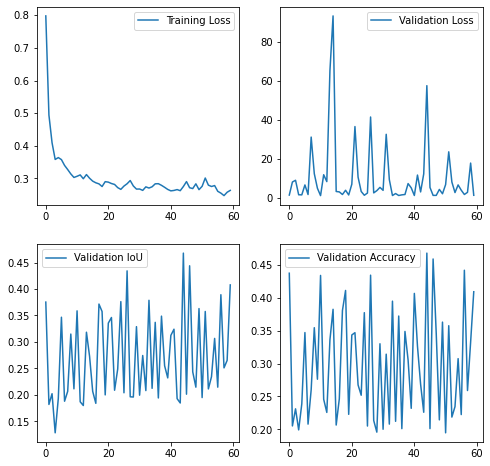

In [11]:
xs = range(EPOCH)
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].plot(xs, records["train_loss"], label="Training Loss")
ax[0, 0].legend()
ax[0, 1].plot(xs, records["val_loss"], label="Validation Loss")
ax[0, 1].legend()
ax[1, 0].plot(xs, records["val_iou"], label="Validation IoU")
ax[1, 0].legend()
ax[1, 1].plot(xs, records["val_acc"], label="Validation Accuracy")
ax[1, 1].legend()

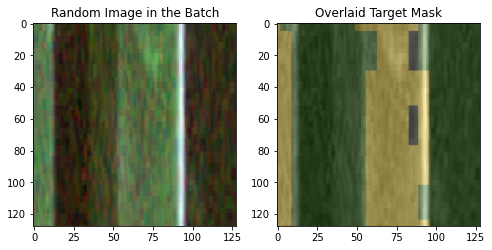

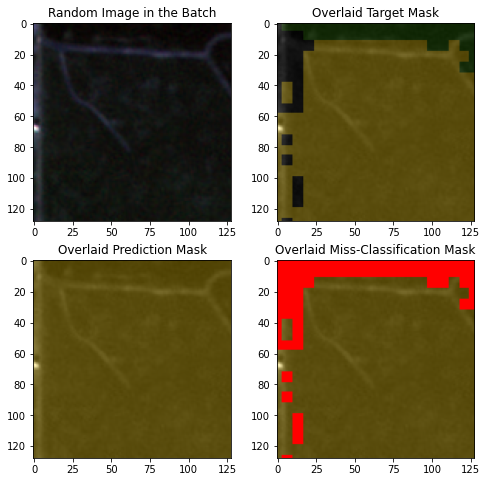

In [26]:
x, y = next(iter(train_loader))
y_pred = model(x.to(device))["out"].argmax(axis=1)
visualize_sample(x, y)
visualize_pred(x, y_pred, y)